# Generalities for DAEs and VAEs

* Import libraries
* Run on GPU if possible
* Create data loaders

In [ ]:
from __future__ import print_function
import argparse
import torch
import torch.utils.data
from torch import nn, optim
from torch.nn import functional as F
from torchvision import datasets, transforms
from torchvision.utils import save_image
from IPython.display import Image, display
import matplotlib.pyplot as plt

# create directory to save results
!mkdir results

# script parameters
batch_size = 128
log_interval = 100

# run on GPU if possible
cuda = torch.cuda.is_available()
device = torch.device("cuda" if cuda else "cpu")

# create data loaders
kwargs = {'num_workers': 1, 'pin_memory': True} if cuda else {}
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
                   transform=transforms.ToTensor()),
    batch_size=batch_size, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, transform=transforms.ToTensor()),
    batch_size=batch_size, shuffle=True, **kwargs)

mkdir: cannot create directory ‘results’: File exists


# Neural Network classes

* Deterministic auto-encoder (DAE)
* Variational auto-encoder (VAE)


In [ ]:
# Deterministic Auto-Encoder (DAE)
class DAE(nn.Module):

    # declare layers
    def __init__(self):
        super(DAE, self).__init__()
        self.fc1 = nn.Linear(784, 400)
        self.fc2 = nn.Linear(400, 20)
        self.fc3 = nn.Linear(20, 400)
        self.fc4 = nn.Linear(400, 784)

    # encoder: one ReLU hidden layer of 400 nodes, one Linear output layer of 20 nodes
    def encode(self, x):
        h = F.relu(self.fc1(x))
        return self.fc2(h)

    # decoder: one ReLU hidden layer of 400 nodes, one sigmoid output layer of 784 nodes
    def decode(self, z):
        h3 = F.relu(self.fc3(z))
        return torch.sigmoid(self.fc4(h3))

    # forward: encoder followed by decoder
    def forward(self, x):
        z = self.encode(x.view(-1, 784))
        return self.decode(z)

# Variational Auto-Encoder (VAE)     
class VAE(nn.Module):

    # declare layers
    def __init__(self):
        super(VAE, self).__init__()

        # dummy assignment until this function is filled in
        self.fc1 = nn.Linear(784, 400)
        self.fc21 = nn.Linear(400, 20)
        self.fc22 = nn.Linear(400, 20)
        self.fc3 = nn.Linear(20, 400)
        self.fc4 = nn.Linear(400, 784)


    # Encoder: one ReLU hidden layer of 400 nodes, two Linear output layers of 20 nodes (means and log_variances)
    # Input: image (array of size 784)
    # Output: means (array of size 20), log_variances (array of size 20)
    def encode(self, x):
        h1 = F.relu(self.fc1(x))
        # dummy assignment until this function is filled in
        means = self.fc21(h1)
        log_variances = self.fc22(h1)
        # means = torch.randn(x.shape[0], 20).to(device)
        # log_variances = torch.randn(x.shape[0], 20).to(device)
        return means, log_variances

    # Reparameterization:
    #
    # Let eps be samples from a Normal(0,1)
    # Input: means (array of size 20), log_variances (array of size 20)
    # Output: embedding (array of size 20 corresponding to means + eps * exponential(log_variances/2))
    def reparameterize(self, means, log_variances):
        std = torch.exp(0.5*log_variances)
        eps = torch.randn_like(std)
        embedding = (means + eps*std).to(device)
        return embedding

        # dummy assignment until this function is filled in
        # embedding = torch.randn(means.shape[0], 20).to(device)

    # Decoder: one ReLU hidden layer of 400 nodes, one sigmoid output layer of 784 nodes
    # Input: embedding (array of size 20)
    # Output: probability of reconstructed image (array of size 784)
    def decode(self, z):
        h3 = F.relu(self.fc3(z))
        # dummy assignment until this function is filled in
        probabilties = torch.sigmoid(self.fc4(h3))
        return probabilties

    # Function forward: encoder, reparameterize, decoder
    # Input: image
    # Output: probability of reconstructed image, means, log_variances
    def forward(self, x):
        means, log_variances = self.encode(x.view(-1, 784))
        probabilities = self.decode(self.reparameterize(means, log_variances))
        return probabilities, means, log_variances
        # dummy assignment until this function is filled in
        # probabilties = torch.rand(x.shape[0],20).to(device)
        # means = torch.randn(x.shape[0], 20).to(device)
        # log_variances = torch.randn(x.shape[0], 20).to(device)
        # return probabilties, means, log_variances

# Loss Functions

In [ ]:
# DAE Loss Function
# Reconstruction loss: binary cross entropy
#
# Inputs:
#    reconstructed_x: reconstructed image
#    x: image
#
# Output:
#    BCE: binary cross entropy  
#
def dae_loss_function(reconstructed_x, x):
    BCE = F.binary_cross_entropy(reconstructed_x, x.view(-1, 784), reduction='sum')
    return BCE

# VAE Loss Function
# Reconstruction loss: binary cross entropy
# KL divergence loss: -0.5 * sum(1 + log_variances - means^2 - exp(log_variances))
#       see Appendix B from VAE paper:
#       Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
#       https://arxiv.org/abs/1312.6114
#
# Inputs: 
#    reconstructed_x: reconstructed image
#    x: image
#    means: array of size 20
#    log_variances: array of size 20
#
# Outputs:
#    total_loss: binary cross entropy + KL divergence (scalar)
#    BCE: binary cross entropy (scalar)
#


def vae_loss_function(reconstructed_x, x, means, log_variances):
    BCE = F.binary_cross_entropy(reconstructed_x, x.view(-1, 784), reduction='sum')
    KLD = -0.5 * torch.sum(1 + log_variances - means.pow(2) - log_variances.exp())
    total_loss = BCE + KLD
    return total_loss, BCE


# Training

In [ ]:
# DAE Training
#
# Inputs:
#    epoch: epoch #
#    model: DAE neural network
#    optimizer: DAE optimizer
#
# Outputs:
#    average_train_BCE: binary cross entropy (scalar)
#
def dae_train(epoch, model, optimizer):
    train_BCE = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.to(device)
        optimizer.zero_grad()
        recon_batch = model(data)
        loss = dae_loss_function(recon_batch, data)
        loss.backward()
        train_BCE += loss.item()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('DAE Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader),
                loss.item() / len(data)))

    average_train_BCE = train_BCE / len(train_loader.dataset)
    print('====> Epoch: {} Average loss: {:.4f}'.format(
          epoch, average_train_BCE))
    return average_train_BCE

# VAE Training
#
# Inputs:
#    epoch: epoch #
#    model: VAE neural network
#    optimizer: VAE optimizer
#
# Outputs:
#    average_train_loss: binary cross entropy + KL divergence (scalar)
#    average_train_BCE: binary cross entropy (scalar)
#
def vae_train(epoch, model, optimizer):
    train_loss = 0
    train_BCE = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.to(device)
        optimizer.zero_grad()
        recon_batch, means, log_variances = model(data)
        loss = vae_loss_function(recon_batch, data, means, log_variances)
        # hmm
        # loss[1].backward()
        loss[0].backward()
        train_loss += loss[0]
        train_BCE += loss[1].item()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('VAE Train Epoch: {} [{}/{} ({:.0f}%)]\tTrain Loss: {:.6f}\t BCE Loss:  {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader),
                loss[0] / len(data),
                loss[1].item() / len(data)))
    average_train_loss = train_loss / len(train_loader.dataset)
    average_train_BCE = train_BCE / len(train_loader.dataset)
    print('====> Epoch: {} Average Train loss: {:.4f}, Average BCE Loss: {:.4f}'.format(
          epoch, average_train_loss , average_train_BCE ))
    return average_train_loss, average_train_BCE

    # dummy assignment until this function is filled in
    # average_train_loss = 0
    # average_train_BCE = 0
    # return average_train_loss, average_train_BCE



# Testing

In [ ]:
# DAE Test
#
# Inputs:
#    epoch: epoch #
#    model: DAE neural network
#
# Outputs:
#    average_test_BCE: binary cross entropy (scalar)
#
def dae_test(epoch, model):
    model.eval()
    test_BCE = 0
    with torch.no_grad():
        for i, (data, _) in enumerate(test_loader):
            data = data.to(device)
            recon_batch = model(data)
            test_BCE += dae_loss_function(recon_batch, data).item()
            if i == 0:
                n = min(data.size(0), 8)
                comparison = torch.cat([data[:n],
                                      recon_batch.view(batch_size, 1, 28, 28)[:n]])
                save_image(comparison.cpu(),
                         'results/reconstruction_' + str(epoch) + '.png', nrow=n)
                print('Sample of reconstructed images (top row are targets and bottom row are reconstructions)')
                display(Image('results/reconstruction_' + str(epoch) + '.png'))

    average_test_BCE = test_BCE / len(test_loader.dataset)
    print('====> Test set loss: {:.4f}'.format(average_test_BCE))
    return average_test_BCE

# VAE Test
#
# Inputs:
#    epoch: epoch #
#    model: VAE neural network
#
# Outputs:
#    average_test_loss: binary cross entropy + KL divergence (scalar)
#    average_test_BCE: binary cross entropy (scalar)
#
def vae_test(epoch, model):
    model.eval()
    test_loss = 0
    test_BCE = 0
    with torch.no_grad():
        for i, (data, _) in enumerate(test_loader):
            data = data.to(device)
            recon_batch, means, log_variances = model(data)
            loss =  vae_loss_function(recon_batch, data, means, log_variances)
            test_loss += loss[0]
            test_BCE += loss[1].item()
            if i == 0:
                n = min(data.size(0), 8)
                comparison = torch.cat([data[:n],
                                      recon_batch.view(batch_size, 1, 28, 28)[:n]])
                save_image(comparison.cpu(),
                         'results/reconstruction_' + str(epoch) + '.png', nrow=n)
                print('Sample of reconstructed images (top row are targets and bottom row are reconstructions)')
                display(Image('results/reconstruction_' + str(epoch) + '.png'))

    average_test_BCE = test_BCE/len(test_loader.dataset)
    average_test_loss = test_loss/len(test_loader.dataset)
    print('====> Test set loss: {:.4f}, Test set BCE Loss: {:.4f}'.format(average_test_loss, average_test_BCE))
    return average_test_loss, average_test_BCE


# Main

DAE Train Epoch: 1 [0/60000 (0%)]	Loss: 543.935791
DAE Train Epoch: 1 [12800/60000 (21%)]	Loss: 142.729065
DAE Train Epoch: 1 [25600/60000 (43%)]	Loss: 111.570000
DAE Train Epoch: 1 [38400/60000 (64%)]	Loss: 99.449432
DAE Train Epoch: 1 [51200/60000 (85%)]	Loss: 90.367065
====> Epoch: 1 Average loss: 128.8352
Sample of reconstructed images (top row are targets and bottom row are reconstructions)


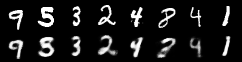

====> Test set loss: 86.3080
Sample of generated images


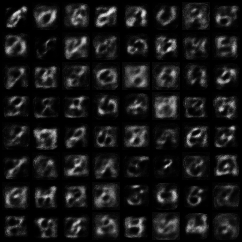



DAE Train Epoch: 2 [0/60000 (0%)]	Loss: 87.713760
DAE Train Epoch: 2 [12800/60000 (21%)]	Loss: 87.803406
DAE Train Epoch: 2 [25600/60000 (43%)]	Loss: 88.718750
DAE Train Epoch: 2 [38400/60000 (64%)]	Loss: 78.260010
DAE Train Epoch: 2 [51200/60000 (85%)]	Loss: 82.690063
====> Epoch: 2 Average loss: 81.9439
Sample of reconstructed images (top row are targets and bottom row are reconstructions)


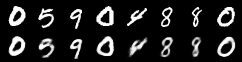

====> Test set loss: 77.6770
Sample of generated images


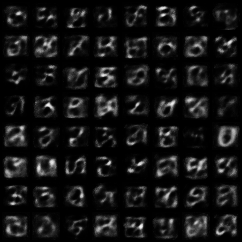



DAE Train Epoch: 3 [0/60000 (0%)]	Loss: 78.578644
DAE Train Epoch: 3 [12800/60000 (21%)]	Loss: 78.257423
DAE Train Epoch: 3 [25600/60000 (43%)]	Loss: 76.246178
DAE Train Epoch: 3 [38400/60000 (64%)]	Loss: 75.897400
DAE Train Epoch: 3 [51200/60000 (85%)]	Loss: 77.562981
====> Epoch: 3 Average loss: 76.6708
Sample of reconstructed images (top row are targets and bottom row are reconstructions)


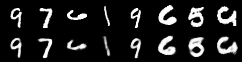

====> Test set loss: 74.4342
Sample of generated images


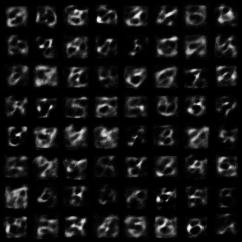



DAE Train Epoch: 4 [0/60000 (0%)]	Loss: 72.919991
DAE Train Epoch: 4 [12800/60000 (21%)]	Loss: 73.874649
DAE Train Epoch: 4 [25600/60000 (43%)]	Loss: 69.721405
DAE Train Epoch: 4 [38400/60000 (64%)]	Loss: 71.044540
DAE Train Epoch: 4 [51200/60000 (85%)]	Loss: 75.562027
====> Epoch: 4 Average loss: 74.0554
Sample of reconstructed images (top row are targets and bottom row are reconstructions)


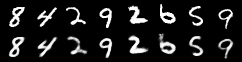

====> Test set loss: 72.5367
Sample of generated images


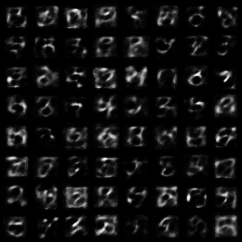



DAE Train Epoch: 5 [0/60000 (0%)]	Loss: 75.267212
DAE Train Epoch: 5 [12800/60000 (21%)]	Loss: 74.140366
DAE Train Epoch: 5 [25600/60000 (43%)]	Loss: 71.558868
DAE Train Epoch: 5 [38400/60000 (64%)]	Loss: 73.246765
DAE Train Epoch: 5 [51200/60000 (85%)]	Loss: 74.071396
====> Epoch: 5 Average loss: 72.3168
Sample of reconstructed images (top row are targets and bottom row are reconstructions)


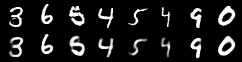

====> Test set loss: 71.0905
Sample of generated images


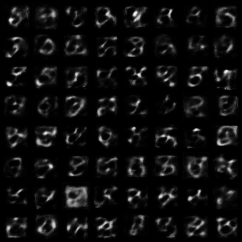



DAE Train Epoch: 6 [0/60000 (0%)]	Loss: 71.734932
DAE Train Epoch: 6 [12800/60000 (21%)]	Loss: 70.718170
DAE Train Epoch: 6 [25600/60000 (43%)]	Loss: 71.903526
DAE Train Epoch: 6 [38400/60000 (64%)]	Loss: 71.204636
DAE Train Epoch: 6 [51200/60000 (85%)]	Loss: 68.927460
====> Epoch: 6 Average loss: 71.0501
Sample of reconstructed images (top row are targets and bottom row are reconstructions)


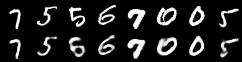

====> Test set loss: 70.3474
Sample of generated images


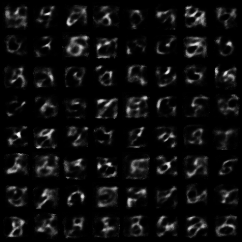



DAE Train Epoch: 7 [0/60000 (0%)]	Loss: 73.854317
DAE Train Epoch: 7 [12800/60000 (21%)]	Loss: 72.085587
DAE Train Epoch: 7 [25600/60000 (43%)]	Loss: 74.577835
DAE Train Epoch: 7 [38400/60000 (64%)]	Loss: 68.870178
DAE Train Epoch: 7 [51200/60000 (85%)]	Loss: 68.787727
====> Epoch: 7 Average loss: 70.0791
Sample of reconstructed images (top row are targets and bottom row are reconstructions)


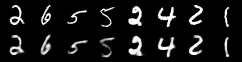

====> Test set loss: 69.4995
Sample of generated images


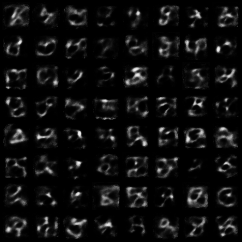



DAE Train Epoch: 8 [0/60000 (0%)]	Loss: 69.798248
DAE Train Epoch: 8 [12800/60000 (21%)]	Loss: 68.787155
DAE Train Epoch: 8 [25600/60000 (43%)]	Loss: 69.795242
DAE Train Epoch: 8 [38400/60000 (64%)]	Loss: 69.461617
DAE Train Epoch: 8 [51200/60000 (85%)]	Loss: 71.176743
====> Epoch: 8 Average loss: 69.3062
Sample of reconstructed images (top row are targets and bottom row are reconstructions)


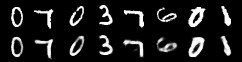

====> Test set loss: 68.8599
Sample of generated images


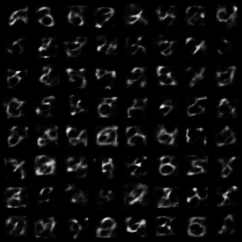



DAE Train Epoch: 9 [0/60000 (0%)]	Loss: 67.259567
DAE Train Epoch: 9 [12800/60000 (21%)]	Loss: 68.676277
DAE Train Epoch: 9 [25600/60000 (43%)]	Loss: 68.214218
DAE Train Epoch: 9 [38400/60000 (64%)]	Loss: 69.287308
DAE Train Epoch: 9 [51200/60000 (85%)]	Loss: 71.794403
====> Epoch: 9 Average loss: 68.6688
Sample of reconstructed images (top row are targets and bottom row are reconstructions)


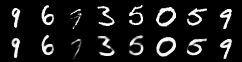

====> Test set loss: 68.2544
Sample of generated images


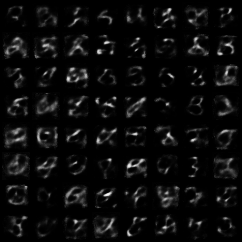



DAE Train Epoch: 10 [0/60000 (0%)]	Loss: 68.075912
DAE Train Epoch: 10 [12800/60000 (21%)]	Loss: 71.349976
DAE Train Epoch: 10 [25600/60000 (43%)]	Loss: 67.475174
DAE Train Epoch: 10 [38400/60000 (64%)]	Loss: 65.418320
DAE Train Epoch: 10 [51200/60000 (85%)]	Loss: 65.420105
====> Epoch: 10 Average loss: 68.1345
Sample of reconstructed images (top row are targets and bottom row are reconstructions)


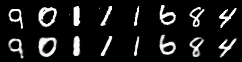

====> Test set loss: 67.9041
Sample of generated images


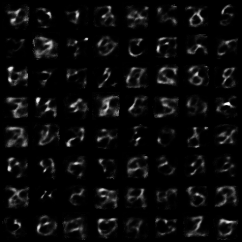

In [ ]:
# train and test DAE
epochs = 10
dae_average_train_BCE = []
dae_average_test_BCE = []
dae_model = DAE().to(device)
dae_optimizer = optim.Adam(dae_model.parameters(), lr=1e-3)
for epoch in range(1, epochs + 1):
    average_train_BCE = dae_train(epoch, dae_model, dae_optimizer)
    dae_average_train_BCE.append(average_train_BCE)
    average_test_BCE = dae_test(epoch, dae_model)
    dae_average_test_BCE.append(average_test_BCE)
    with torch.no_grad():
        sample = torch.randn(64, 20).to(device)
        sample = dae_model.decode(sample).cpu()
        save_image(sample.view(64, 1, 28, 28),
                   'results/sample_' + str(epoch) + '.png')
        print('Sample of generated images')
        display(Image('results/sample_' + str(epoch) + '.png'))
        print('\n')



VAE Train Epoch: 1 [0/60000 (0%)]	Train Loss: 551.135193	 BCE Loss:  551.046997
VAE Train Epoch: 1 [12800/60000 (21%)]	Train Loss: 182.972900	 BCE Loss:  173.281052
VAE Train Epoch: 1 [25600/60000 (43%)]	Train Loss: 156.408752	 BCE Loss:  141.381210
VAE Train Epoch: 1 [38400/60000 (64%)]	Train Loss: 148.534805	 BCE Loss:  129.596085
VAE Train Epoch: 1 [51200/60000 (85%)]	Train Loss: 139.607727	 BCE Loss:  120.768646
====> Epoch: 1 Average Train loss: 165.0768, Average BCE Loss: 149.8812
Sample of reconstructed images (top row are targets and bottom row are reconstructions)


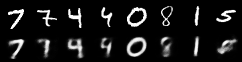

====> Test set loss: 128.2640, Test set BCE Loss: 107.5380
Sample of generated images


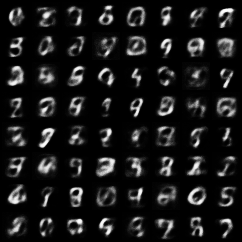



VAE Train Epoch: 2 [0/60000 (0%)]	Train Loss: 125.410233	 BCE Loss:  105.598763
VAE Train Epoch: 2 [12800/60000 (21%)]	Train Loss: 125.378059	 BCE Loss:  105.205353
VAE Train Epoch: 2 [25600/60000 (43%)]	Train Loss: 122.843384	 BCE Loss:  100.687836
VAE Train Epoch: 2 [38400/60000 (64%)]	Train Loss: 118.071350	 BCE Loss:  96.610001
VAE Train Epoch: 2 [51200/60000 (85%)]	Train Loss: 121.643585	 BCE Loss:  98.440231
====> Epoch: 2 Average Train loss: 122.2643, Average BCE Loss: 100.3625
Sample of reconstructed images (top row are targets and bottom row are reconstructions)


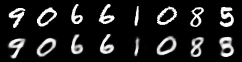

====> Test set loss: 116.2744, Test set BCE Loss: 92.9434
Sample of generated images


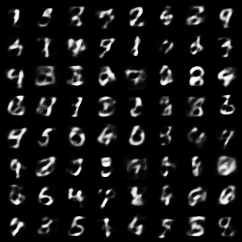



VAE Train Epoch: 3 [0/60000 (0%)]	Train Loss: 116.204002	 BCE Loss:  92.920311
VAE Train Epoch: 3 [12800/60000 (21%)]	Train Loss: 113.484192	 BCE Loss:  90.978241
VAE Train Epoch: 3 [25600/60000 (43%)]	Train Loss: 110.449997	 BCE Loss:  86.612457
VAE Train Epoch: 3 [38400/60000 (64%)]	Train Loss: 115.886459	 BCE Loss:  92.085739
VAE Train Epoch: 3 [51200/60000 (85%)]	Train Loss: 110.569389	 BCE Loss:  86.819862
====> Epoch: 3 Average Train loss: 114.8730, Average BCE Loss: 91.0934
Sample of reconstructed images (top row are targets and bottom row are reconstructions)


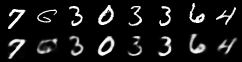

====> Test set loss: 111.8292, Test set BCE Loss: 87.5198
Sample of generated images


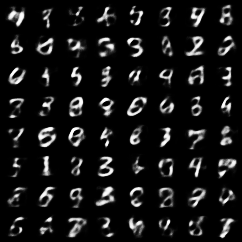



VAE Train Epoch: 4 [0/60000 (0%)]	Train Loss: 116.689362	 BCE Loss:  92.164253
VAE Train Epoch: 4 [12800/60000 (21%)]	Train Loss: 112.936066	 BCE Loss:  88.754303
VAE Train Epoch: 4 [25600/60000 (43%)]	Train Loss: 111.103043	 BCE Loss:  86.986359
VAE Train Epoch: 4 [38400/60000 (64%)]	Train Loss: 105.860046	 BCE Loss:  81.865646
VAE Train Epoch: 4 [51200/60000 (85%)]	Train Loss: 114.875580	 BCE Loss:  90.121590
====> Epoch: 4 Average Train loss: 111.7637, Average BCE Loss: 87.3483
Sample of reconstructed images (top row are targets and bottom row are reconstructions)


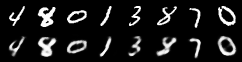

====> Test set loss: 109.8311, Test set BCE Loss: 84.9799
Sample of generated images


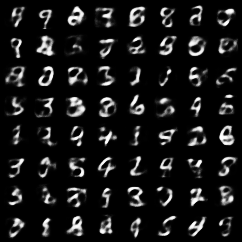



VAE Train Epoch: 5 [0/60000 (0%)]	Train Loss: 109.351913	 BCE Loss:  84.595856
VAE Train Epoch: 5 [12800/60000 (21%)]	Train Loss: 108.072769	 BCE Loss:  84.056770
VAE Train Epoch: 5 [25600/60000 (43%)]	Train Loss: 108.483360	 BCE Loss:  83.616447
VAE Train Epoch: 5 [38400/60000 (64%)]	Train Loss: 111.088837	 BCE Loss:  86.067612
VAE Train Epoch: 5 [51200/60000 (85%)]	Train Loss: 109.874275	 BCE Loss:  85.355301
====> Epoch: 5 Average Train loss: 110.0029, Average BCE Loss: 85.2980
Sample of reconstructed images (top row are targets and bottom row are reconstructions)


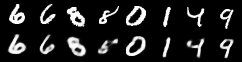

====> Test set loss: 108.4112, Test set BCE Loss: 82.9493
Sample of generated images


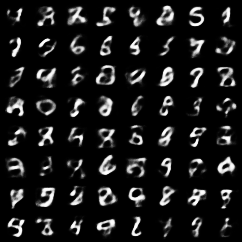



VAE Train Epoch: 6 [0/60000 (0%)]	Train Loss: 110.265778	 BCE Loss:  84.766083
VAE Train Epoch: 6 [12800/60000 (21%)]	Train Loss: 111.802536	 BCE Loss:  86.655426
VAE Train Epoch: 6 [25600/60000 (43%)]	Train Loss: 110.043350	 BCE Loss:  85.153824
VAE Train Epoch: 6 [38400/60000 (64%)]	Train Loss: 108.666183	 BCE Loss:  83.614578
VAE Train Epoch: 6 [51200/60000 (85%)]	Train Loss: 103.459862	 BCE Loss:  79.804962
====> Epoch: 6 Average Train loss: 108.7970, Average BCE Loss: 83.9081
Sample of reconstructed images (top row are targets and bottom row are reconstructions)


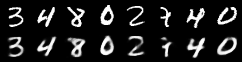

====> Test set loss: 107.7817, Test set BCE Loss: 82.5834
Sample of generated images


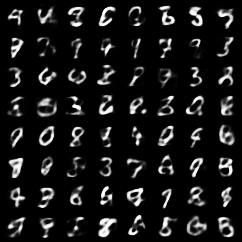



VAE Train Epoch: 7 [0/60000 (0%)]	Train Loss: 109.928810	 BCE Loss:  84.392181
VAE Train Epoch: 7 [12800/60000 (21%)]	Train Loss: 110.167030	 BCE Loss:  84.799965
VAE Train Epoch: 7 [25600/60000 (43%)]	Train Loss: 104.755432	 BCE Loss:  80.413757
VAE Train Epoch: 7 [38400/60000 (64%)]	Train Loss: 106.648819	 BCE Loss:  81.562592
VAE Train Epoch: 7 [51200/60000 (85%)]	Train Loss: 104.651527	 BCE Loss:  79.695251
====> Epoch: 7 Average Train loss: 107.8939, Average BCE Loss: 82.9130
Sample of reconstructed images (top row are targets and bottom row are reconstructions)


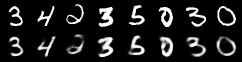

====> Test set loss: 106.9010, Test set BCE Loss: 81.8333
Sample of generated images


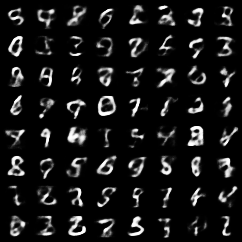



VAE Train Epoch: 8 [0/60000 (0%)]	Train Loss: 110.367043	 BCE Loss:  84.798363
VAE Train Epoch: 8 [12800/60000 (21%)]	Train Loss: 109.180817	 BCE Loss:  83.673973
VAE Train Epoch: 8 [25600/60000 (43%)]	Train Loss: 109.926506	 BCE Loss:  84.194077
VAE Train Epoch: 8 [38400/60000 (64%)]	Train Loss: 104.479668	 BCE Loss:  80.079544
VAE Train Epoch: 8 [51200/60000 (85%)]	Train Loss: 108.181236	 BCE Loss:  82.563354
====> Epoch: 8 Average Train loss: 107.2430, Average BCE Loss: 82.1548
Sample of reconstructed images (top row are targets and bottom row are reconstructions)


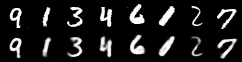

====> Test set loss: 106.4420, Test set BCE Loss: 81.2284
Sample of generated images


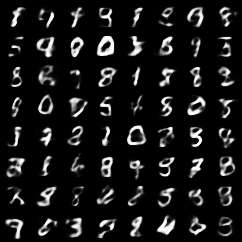



VAE Train Epoch: 9 [0/60000 (0%)]	Train Loss: 107.581467	 BCE Loss:  82.534866
VAE Train Epoch: 9 [12800/60000 (21%)]	Train Loss: 102.949028	 BCE Loss:  78.165909
VAE Train Epoch: 9 [25600/60000 (43%)]	Train Loss: 105.431732	 BCE Loss:  80.481323
VAE Train Epoch: 9 [38400/60000 (64%)]	Train Loss: 104.222458	 BCE Loss:  78.586319
VAE Train Epoch: 9 [51200/60000 (85%)]	Train Loss: 104.171654	 BCE Loss:  79.388069
====> Epoch: 9 Average Train loss: 106.6427, Average BCE Loss: 81.5342
Sample of reconstructed images (top row are targets and bottom row are reconstructions)


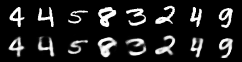

====> Test set loss: 105.9218, Test set BCE Loss: 80.7928
Sample of generated images


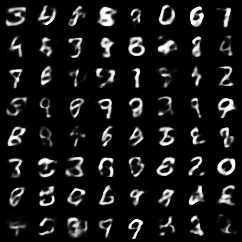



VAE Train Epoch: 10 [0/60000 (0%)]	Train Loss: 102.747650	 BCE Loss:  77.980492
VAE Train Epoch: 10 [12800/60000 (21%)]	Train Loss: 104.826416	 BCE Loss:  80.245758
VAE Train Epoch: 10 [25600/60000 (43%)]	Train Loss: 108.080559	 BCE Loss:  82.541298
VAE Train Epoch: 10 [38400/60000 (64%)]	Train Loss: 103.418236	 BCE Loss:  79.285820
VAE Train Epoch: 10 [51200/60000 (85%)]	Train Loss: 109.508499	 BCE Loss:  83.902191
====> Epoch: 10 Average Train loss: 106.2197, Average BCE Loss: 81.0321
Sample of reconstructed images (top row are targets and bottom row are reconstructions)


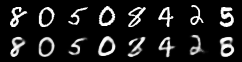

====> Test set loss: 105.7534, Test set BCE Loss: 80.3739
Sample of generated images


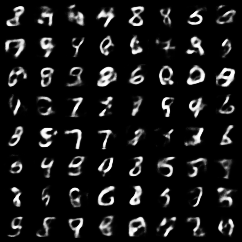

In [ ]:
# train and test VAE
epochs = 10
vae_average_train_losses = []
vae_average_train_BCE = []
vae_average_test_losses = []
vae_average_test_BCE = []
vae_model = VAE().to(device)
vae_optimizer = optim.Adam(vae_model.parameters(), lr=1e-3)
for epoch in range(1, epochs + 1):
    average_train_loss, average_train_BCE = vae_train(epoch, vae_model, vae_optimizer)
    vae_average_train_losses.append(average_train_loss)
    vae_average_train_BCE.append(average_train_BCE)
    average_test_loss, average_test_BCE = vae_test(epoch, vae_model)
    vae_average_test_losses.append(average_test_loss)
    vae_average_test_BCE.append(average_test_BCE)
    with torch.no_grad():
        sample = torch.randn(64, 20).to(device)
        sample = vae_model.decode(sample).cpu()
        save_image(sample.view(64, 1, 28, 28),
                   'results/sample_' + str(epoch) + '.png')
        print('Sample of generated images')
        display(Image('results/sample_' + str(epoch) + '.png'))
        print('\n')

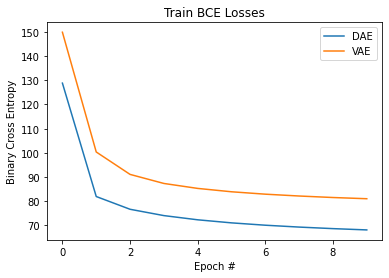

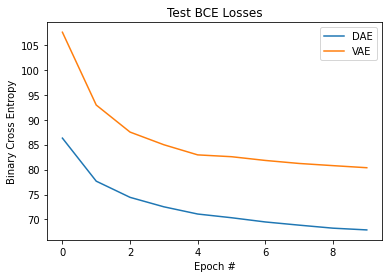

In [ ]:

# Plot Train BCE Losses
plt.plot(dae_average_train_BCE)
plt.plot(vae_average_train_BCE)
plt.title('Train BCE Losses')
plt.ylabel('Binary Cross Entropy')
plt.xlabel('Epoch #')
plt.legend(['DAE','VAE'], loc='upper right')
plt.show()

# Plot Test BCE Losses
plt.plot(dae_average_test_BCE)
plt.plot(vae_average_test_BCE)
plt.title('Test BCE Losses')
plt.ylabel('Binary Cross Entropy')
plt.xlabel('Epoch #')
plt.legend(['DAE','VAE'], loc='upper right')
plt.show()

In terms of BCE and reconstruced image, DAE performs better than VAE.  This makes sense as DAE is deterministic and focuses on learning a compressed form of the original input and then decompressing it back to match the original input. While VAE learns the probabilistic distribution representing the data. Hence, DAE has lower BCE and better reconstructed images than VAE. 

However, in terms of generated images, DAE's results are fuzzy and unrecognizable while VAE's results are much better and more similar to handwritten numbers. This makes sense as VAE learns the probabilistic distribution of the original input and can use the learned distrbution to generate sampled outputs.